In [1]:
### Libraries 
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Input, Lambda, Dropout, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, Bidirectional, SpatialDropout1D 
import keras.backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Pour colab, test GPU 
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# To be replace by your project's path

#path = "/users/dorian/Documents/M2_MASH/NLP/Project/Data/"
#path = "/Users/dorian/Desktop/jigsaw-toxic-comment-classification-challenge/"
path = '/content/drive/MyDrive/'


In [5]:
train = pd.read_csv(path + "train.csv", sep=',', header=0)
train.columns=['id', 'comment_text', 'toxic', 'severe_toxic',
                        'obscene', 'threat', 'insult', 'identity_hate']

print("taille_échantillon_train: ", train.shape[0])

test = pd.read_csv(path + "test.csv", sep=',', header=0)
test.columns=['id', 'comment_text']

print("taille_échantillon_test: ", test.shape[0])

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[label_names].values

taille_échantillon_train:  159571
taille_échantillon_test:  153164


# Visualization

In [6]:
category_data = train.drop(['id', 'comment_text'], axis=1)

In [7]:
counts_category = []
categories = list(category_data.columns.values)

for i in categories:
    counts_category.append((i, category_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])
dataframe.head(6)

,Labels,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0.5, 0, 'Labels')

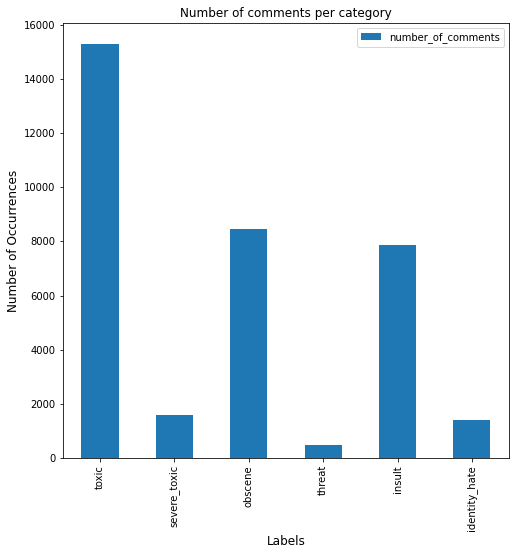

In [8]:
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

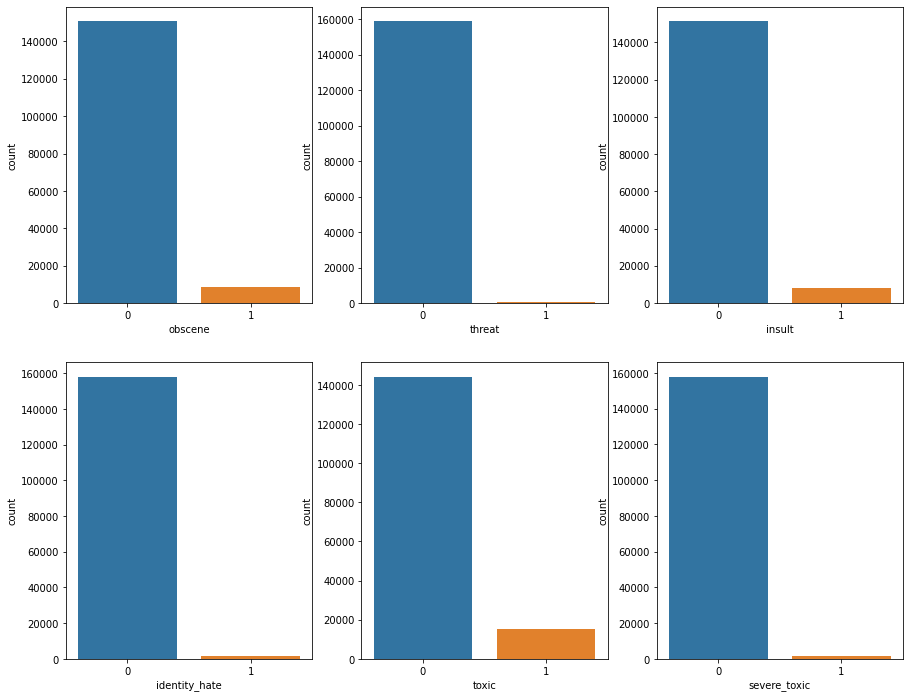

In [9]:
fig, plots = plt.subplots(2,3,figsize=(15,12))
plot1, plot2, plot3, plot4, plot5, plot6 = plots.flatten()
sns.countplot(train['obscene'], ax = plot1)
sns.countplot(train['threat'], ax = plot2)
sns.countplot(train['insult'], ax = plot3)
sns.countplot(train['identity_hate'], ax = plot4)
sns.countplot(train['toxic'], ax = plot5)
sns.countplot(train['severe_toxic'], ax = plot6)

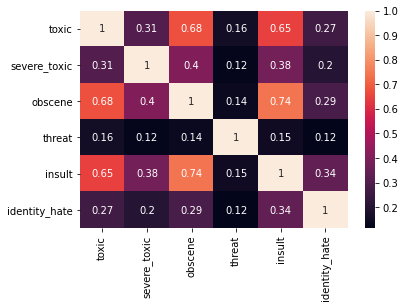

In [10]:
target_data = train.drop(['id', 'comment_text'], axis=1)
corrMatrix = target_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [11]:
Stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
             "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", 
             "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", 
             "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
             "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", 
             "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", 
             "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", 
             "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", 
             "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", 
             "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", 
             "now"]

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('[^A-Za-z\' ]+', '',text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = ' '.join([word for word in text.split() if word not in Stopwords])   
    return text

train["comment_text"] = train["comment_text"].apply(clean_text)
test["comment_text"] = test["comment_text"].apply(clean_text)

In [13]:
train_data = train["comment_text"]
test_data = test["comment_text"]
train_label=train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]

### CBOW

In [ ]:
max_features=20000
maxlen=150
embed_size=300

tokenizer = Tokenizer(num_words = max_features) 
tokenizer.fit_on_texts(train_data)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(train_data)
test_final = tokenizer.texts_to_sequences(test_data)

# Each sentence is cut after the 150th word
train_padded =pad_sequences(train_final, maxlen=maxlen)
test_padded =pad_sequences(test_final, maxlen=maxlen)
print("Shape of training data",train_padded.shape)
print("Shape of testing data",test_padded.shape)

# A changer avec le path correspondant 
path_embedded = "/Users/dorian/Downloads/"

EMBEDDING_FILE = path + "glove.840B.300d.txt"

embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

word_index = tokenizer.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))

for word, i in word_index.items():
    if i >= max_features:
        continue
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Shape of training data (159571, 150)
Shape of testing data (153164, 150)


In [ ]:
model_cbow = Sequential()

model_cbow.add(Embedding(max_features,
                    embed_size,
                    input_length=maxlen))
model_cbow.add(Dropout(0.2))
model_cbow.add(Lambda(lambda x: K.sum(x, axis=1)))
model_cbow.add(Dense(6, activation = 'sigmoid'))

epochs = 1

model_cbow.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_cbow.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          6000000   
_________________________________________________________________
dropout (Dropout)            (None, 150, 300)          0         
_________________________________________________________________
lambda (Lambda)              (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 1806      
Total params: 6,001,806
Trainable params: 6,001,806
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_cbow.fit(train_padded, train_label, epochs=epochs)

submission = pd.read_csv(path + 'sample_submission.csv')
y_pred = model_cbow.predict(test_padded)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission_cbow.csv', index=False)

4987/4987 [==============================] - 301s 60ms/step - loss: 0.1156 - accuracy: 0.4509


# Preprocessing pour le reste des modèles 

In [14]:
max_features=100000
maxlen=150
embed_size=300

tokenizer = Tokenizer(num_words = max_features) 
tokenizer.fit_on_texts(train_data)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(train_data)
test_final = tokenizer.texts_to_sequences(test_data)

# Each sentence is cut after the 150th word
train_padded =pad_sequences(train_final, maxlen=maxlen)
test_padded =pad_sequences(test_final, maxlen=maxlen)
print("Shape of training data",train_padded.shape)
print("Shape of testing data",test_padded.shape)

# A changer avec le path correspondant 
path_embedded = "/Users/dorian/Downloads/"

EMBEDDING_FILE = path + "glove.840B.300d.txt"

embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

word_index = tokenizer.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))

for word, i in word_index.items():
    if i >= max_features:
        continue
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Shape of training data (159571, 150)
Shape of testing data (153164, 150)


# CNN

In [ ]:
model_CNN = Sequential()
model_CNN.add(Embedding(max_features,
                    embed_size,
                    input_length=maxlen))
model_CNN.add(Dropout(0.2))
model_CNN.add(Conv1D(128, 5, activation='relu'))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dense(40, activation='relu'))
model_CNN.add(Dense(6, activation='sigmoid'))
model_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_CNN.summary()

epochs = 1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          30000000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 146, 128)          192128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 246       
Total params: 30,197,534
Trainable params: 30,197,534
Non-trainable params: 0
__________________________________________

In [ ]:
model_CNN.fit(train_padded, train_label, epochs=epochs)

submission = pd.read_csv(path + 'sample_submission.csv')
y_pred = model_CNN.predict(test_padded)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission_cnn.csv', index=False)

4987/4987 [==============================] - 1434s 281ms/step - loss: 0.0779 - accuracy: 0.9641


# LSTM 

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embed_size, input_length = maxlen))
model.add(LSTM(units = 64, dropout = 0.2, return_sequences=True))
model.add(LSTM(units = 64, dropout = 0.2))
model.add(Dense(units = 6, activation = 'sigmoid'))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 300)          30000000  
_________________________________________________________________
lstm_6 (LSTM)                (None, 150, 64)           93440     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
Total params: 30,126,854
Trainable params: 30,126,854
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_padded, train_label, batch_size = 32, epochs = 1)

4987/4987 [==============================] - 1434s 287ms/step - loss: 0.0889 - accuracy: 0.9873


In [ ]:
submission = pd.read_csv(path + 'sample_submission.csv')
y_pred = model.predict(test_padded)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission_lstm_64.csv', index=False)

## CNN embd

In [ ]:
model_CNN_embd = Sequential()

model_CNN_embd.add(Embedding(max_features, embed_size, weights=[embedding_matrix],
                              trainable=True,input_length=maxlen))
model_CNN_embd.add(Dropout(0.2))
model_CNN_embd.add(Conv1D(128, 5, activation='relu'))
model_CNN_embd.add(GlobalMaxPooling1D())
model_CNN_embd.add(Dense(40, activation='relu'))
model_CNN_embd.add(Dense(6, activation='sigmoid'))
model_CNN_embd.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_CNN_embd.summary()

epochs = 1

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 300)          30000000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 128)          192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                5160      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 246       
Total params: 30,197,534
Trainable params: 30,197,534
Non-trainable params: 0
__________________________________________

In [ ]:
model_CNN_embd.fit(train_padded, train_label, epochs=epochs)

4987/4987 [==============================] - 1362s 273ms/step - loss: 0.0611 - accuracy: 0.9022


In [ ]:
submission = pd.read_csv(path + 'sample_submission.csv')
y_pred = model_CNN_embd.predict(test_padded)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission_cnn_embd.csv', index=False)

## LSTM_embd

In [18]:
model = Sequential()
model.add(Embedding(max_features, embed_size, weights=[embedding_matrix],
                              trainable=True,input_length=maxlen))
model.add(LSTM(units = 64, dropout = 0.2, return_sequences=True))
model.add(LSTM(units = 64, dropout = 0.2))
model.add(Dense(units = 6, activation = 'sigmoid'))
model.summary()

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 300)          30000000  
_________________________________________________________________
lstm_4 (LSTM)                (None, 150, 64)           93440     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 30,126,854
Trainable params: 30,126,854
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(train_padded, train_label, batch_size = 32, epochs = 1)

4987/4987 [==============================] - 1424s 285ms/step - loss: 0.0702 - accuracy: 0.9656


In [20]:
submission = pd.read_csv(path + 'sample_submission.csv')
y_pred = model.predict(test_padded)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission_lstm_embd.csv', index=False)

## BI LSTM

In [29]:
# Build Model
inp = Input(shape=(maxlen,))

x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
x = SpatialDropout1D(0.4)(x)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15))(x)
x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])

out = Dense(6, activation='sigmoid')(x)

model = Model(inp, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 150, 300)     30000000    input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 150, 300)     0           embedding_6[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 150, 256)     439296      spatial_dropout1d_3[0][0]        
____________________________________________________________________________________________

In [30]:
epochs = 1

model.fit(train_padded, train_label, epochs = epochs)

4987/4987 [==============================] - 1479s 296ms/step - loss: 0.0622 - accuracy: 0.9022


In [31]:
submission = pd.read_csv(path + 'sample_submission.csv')
y_pred = model.predict(test_padded)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission_bi_lstm_.csv', index=False)